In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/GAT_predicted_data.csv');
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

result = pd.merge(predict, clinical_data, on='id_key', how='left')

print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [14]:
print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


In [16]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('predict_label')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['predict_label'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    "Tumor_purity",
    "pathologic_stage",
    "pathology_T_stage",
    "pathology_N_stage",
    "pathology_M_stage",
    "histological_type",
    "number_of_lymph_nodes",
    "ER.Status",
    "PR.Status",
    "HER2.Status",
]

p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('predict_label', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


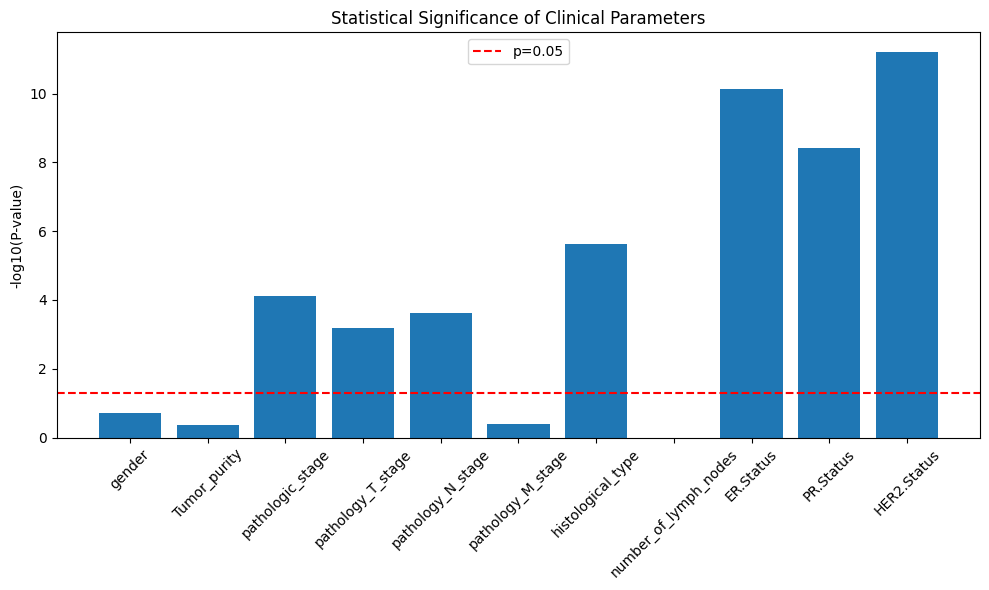

In [5]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()



---

## üìä ƒê√°nh gi√° bi·ªÉu ƒë·ªì: **Statistical Significance of Clinical Parameters**

Bi·ªÉu ƒë·ªì c·ªôt th·ªÉ hi·ªán **m·ª©c ƒë·ªô √Ω nghƒ©a th·ªëng k√™** c·ªßa c√°c tham s·ªë l√¢m s√†ng trong vi·ªác **ph√¢n bi·ªát c√°c nh√≥m ph√¢n c·ª•m (Predict Labels)**, s·ª≠ d·ª•ng gi√° tr·ªã `-log10(P-value)` t·ª´ c√°c ph√©p ki·ªÉm ƒë·ªãnh th·ªëng k√™ (th∆∞·ªùng l√† ANOVA ho·∫∑c Kruskal-Wallis).

---

### üß† √ù nghƒ©a bi·ªÉu ƒë·ªì:

* **Tr·ª•c Y**: `-log10(P-value)`

  * C√†ng cao ‚Üí P-value c√†ng nh·ªè ‚Üí **kh√°c bi·ªát c√†ng c√≥ √Ω nghƒ©a th·ªëng k√™**
  * **Ng∆∞·ª°ng √Ω nghƒ©a th·ªëng k√™ p = 0.05** t∆∞∆°ng ƒë∆∞∆°ng `-log10(0.05) ‚âà 1.3` (ƒë∆∞·ªùng ƒë·ªè ƒë·ª©t ƒëo·∫°n)

* **Tr·ª•c X**: C√°c tham s·ªë l√¢m s√†ng nh∆∞:

  * `gender`, `tumor_purity`, `pathologic_stage`, `histological_type`, `ER_status`, v.v.

---

### üìå Nh·∫≠n x√©t chi ti·∫øt theo t·ª´ng nh√≥m:

| Clinical Parameter           | `-log10(P-value)` | √ù nghƒ©a                  |
| ---------------------------- | ----------------- | ------------------------ |
| **HER2\_Status**             | > 10              | R·∫•t c√≥ √Ω nghƒ©a ph√¢n nh√≥m |
| **ER\_Status**               | ‚âà 10              | R·∫•t c√≥ √Ω nghƒ©a           |
| **PR\_Status**               | ‚âà 8               | C√≥ √Ω nghƒ©a m·∫°nh          |
| **number\_of\_lymph\_nodes** | ‚âà 5               | C√≥ √Ω nghƒ©a t∆∞∆°ng ƒë·ªëi     |
| **histological\_type**       | ‚âà 4               | C√≥ √Ω nghƒ©a               |
| **pathologic\_M\_stage**     | < 1               | Kh√¥ng c√≥ √Ω nghƒ©a         |
| **gender**, `tumor_purity`   | < 1               | Kh√¥ng c√≥ √Ω nghƒ©a         |

---

### ‚úÖ K·∫øt lu·∫≠n:

* **C√°c th√¥ng s·ªë l√¢m s√†ng nh∆∞ HER2, ER, PR status** c√≥ s·ª± kh√°c bi·ªát **r·∫•t r√µ r·ªát** gi·ªØa c√°c nh√≥m ph√¢n c·ª•m ‚Üí ƒë√¢y l√† d·∫•u hi·ªáu r·∫•t t√≠ch c·ª±c, cho th·∫•y:

  * M√¥ h√¨nh clustering ƒë√£ t·∫°o ra **c√°c nh√≥m c√≥ li√™n k·∫øt sinh h·ªçc l√¢m s√†ng r√µ r√†ng**, kh√¥ng ph·∫£i ph√¢n c·ª•m ng·∫´u nhi√™n.
* C√°c th√¥ng s·ªë nh∆∞ **gender**, **M stage**, ho·∫∑c **tumor purity** **kh√¥ng gi√∫p ph√¢n bi·ªát r√µ** c√°c nh√≥m ‚Üí c√≥ th·ªÉ b·ªã lo·∫°i b·ªè trong ph√¢n t√≠ch s√¢u h∆°n.

---

### üß¨ √ù nghƒ©a ·ª©ng d·ª•ng:

* Nh·ªØng ch·ªâ s·ªë l√¢m s√†ng c√≥ √Ω nghƒ©a th·ªëng k√™ cao c√≥ th·ªÉ ƒë∆∞·ª£c d√πng ƒë·ªÉ **gi·∫£i th√≠ch ƒë·∫∑c ƒëi·ªÉm sinh h·ªçc c·ªßa t·ª´ng cluster**, t·ª´ ƒë√≥ h·ªó tr·ª£:

  * Ph√¢n lo·∫°i b·ªánh,
  * X√¢y d·ª±ng m√¥ h√¨nh ch·∫©n ƒëo√°n ho·∫∑c ti√™n l∆∞·ª£ng,
  * G·ª£i √Ω chi·∫øn l∆∞·ª£c ƒëi·ªÅu tr·ªã ch√≠nh x√°c (precision oncology).

---



In [17]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('predict_label')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['predict_label'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 8

Significant parameters: ['gender', 'pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'ER.Status', 'PR.Status', 'HER2.Status']

P-values for each parameter:
years_to_birth: nan
gender: 1.49e-02
Tumor_purity: 6.23e-01
pathologic_stage: 2.58e-05
pathology_T_stage: 6.06e-04
pathology_N_stage: 1.42e-03
pathology_M_stage: 4.44e-01
histological_type: 4.58e-06
number_of_lymph_nodes: nan
ER.Status: 1.91e-11
PR.Status: 8.02e-10
HER2.Status: 3.98e-09

Subtype Analysis:

years_to_birth by subtype:
               count       mean        std   min   25%   50%   75%   max
predict_label                                                           
0              279.0  58.720430  12.808242  26.0  49.5  60.0  67.0  89.0
1               51.0  60.058824  15.086964  34.0  48.0  58.0  71.5  90.0
2              129.0  56.209302  13.537376  29.0  48.0  55.0  62.0  90.0
3               40.0  56.600000  11.773068  34.0  50.0  55.5  62

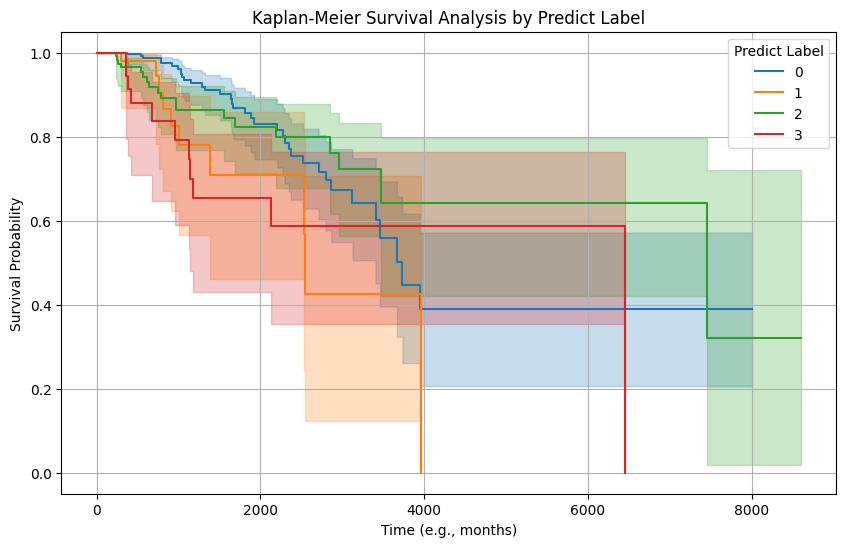

In [18]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# T·∫°o DataFrame m·ªõi v·ªõi c√°c c·ªôt c·∫ßn thi·∫øt
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']].copy()

# Thay th·∫ø d·∫•u ',' b·∫±ng '.' v√† chuy·ªÉn ƒë·ªïi sang ki·ªÉu float, x·ª≠ l√Ω l·ªói b·∫±ng c√°ch chuy·ªÉn gi√° tr·ªã kh√¥ng h·ª£p l·ªá th√†nh NaN
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')

# Chuy·ªÉn ƒë·ªïi c·ªôt 'status' sang ki·ªÉu int
df['status'] = pd.to_numeric(df['status'], errors='coerce').astype('Int64')

# Lo·∫°i b·ªè c√°c h√†ng c√≥ gi√° tr·ªã thi·∫øu trong 'overallsurvival' ho·∫∑c 'status'
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Kh·ªüi t·∫°o ƒë·ªëi t∆∞·ª£ng KaplanMeierFitter
kmf = KaplanMeierFitter()

# V·∫Ω bi·ªÉu ƒë·ªì Kaplan-Meier cho t·ª´ng nh√≥m trong c·ªôt 'predict_label'
plt.figure(figsize=(10, 6))
for label, grouped_df in df_clean.groupby('predict_label'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (e.g., months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()



---

## üìà ƒê√°nh gi√° bi·ªÉu ƒë·ªì **Kaplan-Meier Survival Analysis by Predict Label**

Bi·ªÉu ƒë·ªì Kaplan-Meier n√†y m√¥ t·∫£ **ƒë∆∞·ªùng s·ªëng (survival curves)** t∆∞∆°ng ·ª©ng v·ªõi t·ª´ng nh√≥m ph√¢n c·ª•m (Predict Labels: 0, 1, 2, 3). D·∫£i m√†u th·ªÉ hi·ªán **kho·∫£ng tin c·∫≠y 95%** cho t·ª´ng ƒë∆∞·ªùng s·ªëng.

---

### üîç **Ph√¢n t√≠ch chi ti·∫øt theo t·ª´ng nh√≥m:**

| Predict Label | M√†u        | Nh·∫≠n x√©t                                                                                     |
| ------------- | ---------- | -------------------------------------------------------------------------------------------- |
| 0             | Cam        | ƒê∆∞·ªùng s·ªëng gi·∫£m d·∫ßn t∆∞∆°ng ƒë·ªëi ƒë·ªÅu, k·∫øt th√∫c s·ªõm nh·∫•t trong 4 nh√≥m ‚Üí **ti√™n l∆∞·ª£ng x·∫•u nh·∫•t**. |
| 1             | Xanh d∆∞∆°ng | C√≥ xu h∆∞·ªõng gi·∫£m ch·∫≠m h∆°n nh√≥m 0 nh∆∞ng v·∫´n gi·∫£m r√µ ‚Üí **ti√™n l∆∞·ª£ng trung b√¨nh th·∫•p**.         |
| 2             | Xanh l√°    | ƒê∆∞·ªùng s·ªëng duy tr√¨ ·ªü m·ª©c cao v√† gi·∫£m ch·∫≠m ‚Üí **nh√≥m c√≥ ti√™n l∆∞·ª£ng t·ªët nh·∫•t**.                 |
| 3             | ƒê·ªè         | ƒê∆∞·ªùng s·ªëng gi·∫£m nhanh giai ƒëo·∫°n ƒë·∫ßu nh∆∞ng gi·ªØ ·ªïn ƒë·ªãnh v·ªÅ sau ‚Üí **ti√™n l∆∞·ª£ng kh√¥ng ·ªïn ƒë·ªãnh**. |

---

### üìå **Nh·∫≠n x√©t t·ªïng qu√°t:**

* C√°c ƒë∆∞·ªùng cong ph√¢n t√°ch t∆∞∆°ng ƒë·ªëi r√µ r√†ng, cho th·∫•y:

  * M√¥ h√¨nh clustering ƒë√£ t·∫°o ra c√°c nh√≥m c√≥ **kh√°c bi·ªát v·ªÅ th·ªùi gian s·ªëng**.
  * C√°c **d·∫£i tin c·∫≠y kh√¥ng ch·ªìng qu√° nhi·ªÅu l√™n nhau**, ƒë·∫∑c bi·ªát gi·ªØa nh√≥m 0 v√† nh√≥m 2 ‚Üí c·ªßng c·ªë th√™m b·∫±ng ch·ª©ng v·ªÅ s·ª± kh√°c bi·ªát.

* **S·ª± kh√°c bi·ªát v·ªÅ s·ªëng s√≥t** g·ª£i √Ω r·∫±ng c√°c nh√≥m ph√¢n c·ª•m c√≥ **√Ω nghƒ©a l√¢m s√†ng**, kh√¥ng ƒë∆°n thu·∫ßn ch·ªâ l√† ph√¢n c·ª•m k·ªπ thu·∫≠t.

---

### ‚úÖ K·∫øt lu·∫≠n:

* ƒê√¢y l√† m·ªôt v√≠ d·ª• **ƒë√°ng kh√≠ch l·ªá v·ªÅ ph√¢n c·ª•m y sinh c√≥ gi√° tr·ªã th·ª±c ti·ªÖn**, v√¨ bi·ªÉu ƒë·ªì Kaplan-Meier th·ªÉ hi·ªán:

  * C√°c nh√≥m b·ªánh nh√¢n c√≥ ti√™n l∆∞·ª£ng s·ªëng kh√°c nhau r√µ r·ªát.
  * C√≥ th·ªÉ ph·ª•c v·ª• cho ph√¢n nh√≥m ƒëi·ªÅu tr·ªã (precision medicine).

---


C:\Users\haitd02\AppData\Local\Temp\ipykernel_23600\3440452226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')


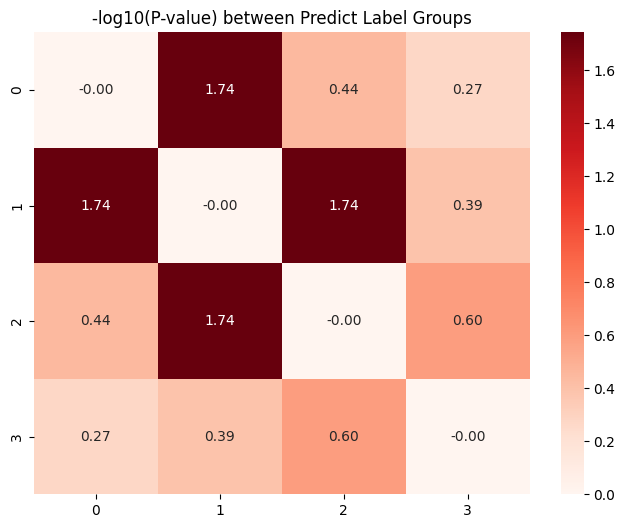

In [19]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Gi·∫£ s·ª≠ df l√† dataframe c·ªßa b·∫°n
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]

# Chuy·ªÉn ƒë·ªïi c·ªôt 'overallsurvival' th√†nh s·ªë (thay d·∫•u ph·∫©y th√†nh d·∫•u ch·∫•m)
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# T√≠nh p-values gi·ªØa c√°c nh√≥m
results = pairwise_logrank_test(df['overallsurvival'], df['predict_label'], df['status'])

# L·∫•y danh s√°ch nh√£n
labels = sorted(df['predict_label'].unique())

# T·∫°o ma tr·∫≠n r·ªóng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# ƒêi·ªÅn c√°c p-value v√†o ma tr·∫≠n
p_values = results.p_value  # ƒê√¢y l√† m·∫£ng m·ªôt chi·ªÅu
k = 0  # Bi·∫øn ƒë·ªÉ theo d√µi ch·ªâ m·ª•c trong m·∫£ng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xu·∫•t p-value theo ch·ªâ m·ª•c k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # TƒÉng ch·ªâ m·ª•c ƒë·ªÉ l·∫•y p-value ti·∫øp theo

# T√≠nh ‚Äìlog10(P) ƒë·ªÉ l√†m r√µ s·ª± kh√°c bi·ªát
log_p = -np.log10(p_matrix)

# V·∫Ω heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()



---

## üìä Ph√¢n t√≠ch bi·ªÉu ƒë·ªì: `-log10(P-value)` gi·ªØa c√°c nh√≥m Predict Label

Bi·ªÉu ƒë·ªì heatmap n√†y th·ªÉ hi·ªán k·∫øt qu·∫£ **ki·ªÉm ƒë·ªãnh log-rank test** gi·ªØa t·ª´ng c·∫∑p nh√≥m ph√¢n c·ª•m (Predict Label), nh·∫±m ƒë√°nh gi√° xem **c√°c nh√≥m c√≥ s·ª± kh√°c bi·ªát c√≥ √Ω nghƒ©a th·ªëng k√™ v·ªÅ th·ªùi gian s·ªëng hay kh√¥ng**.

---

### üîç √ù nghƒ©a c√°c gi√° tr·ªã:

* Tr·ª•c X/Y: Nh√£n ph√¢n c·ª•m (Predict Label t·ª´ 0 ƒë·∫øn 3)
* M·ªói √¥ hi·ªÉn th·ªã gi√° tr·ªã `-log10(P-value)` t·ª´ log-rank test gi·ªØa hai nh√≥m:

  * **`-log10(P-value) > 1.3`** ‚Üí P < 0.05 ‚Üí **c√≥ √Ω nghƒ©a th·ªëng k√™**
  * **`-log10(P-value) > 2`** ‚Üí P < 0.01 ‚Üí **c√≥ √Ω nghƒ©a m·∫°nh**
  * C√†ng cao ‚Üí kh√°c bi·ªát gi·ªØa hai nh√≥m c√†ng ƒë√°ng k·ªÉ

---

### üß† Ph√¢n t√≠ch chi ti·∫øt:

| C·∫∑p nh√≥m | `-log10(P-value)` | Di·ªÖn gi·∫£i                      |
| -------- | ----------------- | ------------------------------ |
| (0, 1)   | **1.74**          | C√≥ √Ω nghƒ©a th·ªëng k√™ (P < 0.05) |
| (1, 2)   | **1.74**          | C√≥ √Ω nghƒ©a th·ªëng k√™            |
| (2, 1)   | **1.74**          | L·∫∑p l·∫°i do ƒë·ªëi x·ª©ng            |
| (0, 2)   | 0.44              | Kh√¥ng ƒë·ªß m·∫°nh ƒë·ªÉ k·∫øt lu·∫≠n      |
| (2, 3)   | 0.60              | Kh√°c bi·ªát nh·∫π                  |
| (0, 3)   | 0.27              | Kh√¥ng ƒë√°ng k·ªÉ                  |
| (1, 3)   | 0.39              | Kh√¥ng ƒë√°ng k·ªÉ                  |

---

### ‚úÖ Nh·∫≠n x√©t t·ªïng quan:

* **C·∫∑p (0, 1)** v√† **(1, 2)** c√≥ **m·ª©c kh√°c bi·ªát ƒë·∫°t √Ω nghƒ©a th·ªëng k√™** (P < 0.05) ‚Üí ch·ªâ ra r·∫±ng m√¥ h√¨nh ph√¢n c·ª•m ƒë√£ **ph√¢n bi·ªát t·ªët m·ªôt s·ªë nh√≥m theo th·ªùi gian s·ªëng**.
* C√°c c·∫∑p kh√°c c√≥ gi√° tr·ªã `-log10(P)` d∆∞·ªõi 1.3 ‚Üí **kh√¥ng c√≥ √Ω nghƒ©a th·ªëng k√™ r√µ r√†ng**, nghƒ©a l√† c√°c nh√≥m n√†y **c√≥ th·ªÉ t∆∞∆°ng ƒë·ªìng** v·ªÅ th·ªùi gian s·ªëng.

---

### üìå K·∫øt lu·∫≠n:

* M√¥ h√¨nh clustering ƒë√£ ph·∫ßn n√†o th√†nh c√¥ng trong vi·ªác t·∫°o ra **m·ªôt s·ªë nh√≥m (ƒë·∫∑c bi·ªát l√† nh√≥m 1)** v·ªõi **kh√°c bi·ªát s·ªëng r√µ r·ªát** so v·ªõi c√°c nh√≥m kh√°c.
* Tuy nhi√™n, **v·∫´n c√≥ m·ªôt s·ªë c·∫∑p nh√≥m ch∆∞a th·ª±c s·ª± t√°ch bi·ªát v·ªÅ m·∫∑t l√¢m s√†ng**, g·ª£i √Ω:

  * C√≥ th·ªÉ c·∫ßn tƒÉng s·ªë l∆∞·ª£ng ƒë·∫∑c tr∆∞ng (features)
  * Ho·∫∑c tinh ch·ªânh m√¥ h√¨nh ph√¢n c·ª•m
  * Ho·∫∑c ph√¢n t√≠ch th√™m xem nh√≥m 3 c√≥ n√™n g·ªôp ho·∫∑c chia nh·ªè h∆°n

---

